In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import faceted as faceted
import xarray as xr
import numpy as np
import glob
import scipy
from scipy import integrate
import dask.bag as db
from dask.distributed import Client, progress

sns.set(font_scale=1.2)
sns.set_palette('hls', 4)
sns.set_style('ticks')

plt.rcParams.update({
    "text.usetex": True,
    "font.size": 10,
    "text.latex.preamble": "\n".join([r'\usepackage{amsmath}'])
}) 

In [3]:
def center_To(d):
    N = int(len(d.x)/2)
    dx = slice(N-1, N+1)
    return d.isel(x=dx, y=dx).mean().values - 290

In [4]:
exps = glob.glob("../data/LES/R_suite/To_R_1.0_km_N_*")
R_1km_branch = {}
for exp in exps:
    N = exp.split('/')[4][14:][:-3]
    ds = xr.open_dataset(exp, decode_cf=True, decode_times=True)
    R_1km_branch[N] = ds     

In [5]:
exps = glob.glob("../data/LES/R_suite/To_R_7.0_km_N_*")
R_7km_branch = {}
for exp in exps:
    N = exp.split('/')[4][14:][:-3]
    ds = xr.open_dataset(exp, decode_cf=True, decode_times=True)
    R_7km_branch[N] = ds     

In [6]:
exps = glob.glob("../data/LES/R_suite/To_R_*_km.nc")
R_suite = {}
for exp in exps:
    R = exp.split('/')[4][5:][:-6]
    ds = xr.open_dataset(exp, decode_cf=True, decode_times=True)
    R_suite[R] = ds

In [7]:
exps = glob.glob("../data/LES/H_suite/To_H_*.nc")
H_suite = {}
for exp in exps:
    H = exp.split('/')[4][5:][:-3]
    ds = xr.open_dataset(exp, decode_cf=True, decode_times=True)
    H_suite[H] = ds

In [8]:
def MTT(z):
    return 31.3*(z+1.1)**(-5/3)

a,b,c,d = [ -2.06190316, -14.70771946,   0.01750799,   0.56364314]

def b_empirical(z):
    return MTT(z) + (a + b*(1 - np.exp(-z/c)))*np.exp(-z/d)

def find_To(Q,R):

    F = 9.81*Q/(1.1*1000*300)
    zhat = 1000/R 
    b = b_empirical(zhat)*F**(2/3)*R**(-1/3)
    Te0 = 290 #K 
    Tanom = b*Te0/10

    return Tanom

find_To_vec = np.vectorize(find_To)

In [9]:
def To_analytical(l):
    Gamma = 6/1000
    g = 9.81
    cp = 1000
    z_t = 15e3 
    z0 = 1e3
    return (np.exp((z_t-z0)/l) - 1)*(g/cp - Gamma)*(l)

In [10]:
Rs = np.logspace(2, 4, 100)
Ts_fixed_Q = find_To_vec(5e4, Rs)

Qs = np.linspace(1,1.1e5,100)
Ts_fixed_R = find_To_vec(Qs, 5e3)

To_strat = To_analytical(5*Rs)

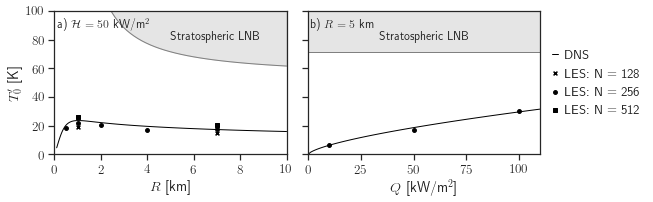

In [46]:
fig, axis = faceted.faceted(1,2, sharex=False, 
                            sharey=True, internal_pad=.3, width=9,
                           left_pad=.75, bottom_pad=.75, right_pad=1.5)

axis[0].plot(Rs/1e3, To_strat, linewidth=1, color='grey')
axis[1].plot(Qs/1e3, To_analytical(5*5000)*np.ones(len(Qs)), 
             linewidth=1, color='grey')

axis[0].fill_between(Rs[40:]/1e3, To_strat[40:], 1e3, color='grey', alpha=.2)
axis[1].fill_between(Qs/1e3, To_analytical(5*5000)*np.ones(len(Qs)), 
                     1e3, color='grey', alpha=.2)

axis[0].plot(Rs/1e3, Ts_fixed_Q, linewidth=1, color='black', label="DNS")
axis[1].plot(Qs/1e3, Ts_fixed_R, linewidth=1, color='black', label="DNS")

axis[0].scatter(1, center_To(R_1km_branch["128"].tabs), marker="x", 
                    color='black', label="LES: N = 128", s=15)
axis[0].scatter(7, center_To(R_7km_branch["128"].tabs), marker="x", 
                    color='black', s=15)

i = 0 
for key in R_suite:
    if i == 0:
        axis[0].scatter(float(key), center_To(R_suite[key].tabs), 
                        color='black', label="LES: N = 256", s=15)
    else:
        axis[0].scatter(float(key), center_To(R_suite[key].tabs), 
                        color='black', s=15)
    i += 1

axis[0].scatter(1, center_To(R_1km_branch["512"].tabs), marker="s",
                    color='black', label="LES: N = 512", s = 15)
axis[0].scatter(7, center_To(R_7km_branch["512"].tabs), marker="s", 
                    color='black', s = 15)

i = 0 
for key in H_suite:
    if i == 0:
        axis[1].scatter(float(key), center_To(H_suite[key].tabs), 
                        color='black', s = 15)
    else:
        axis[1].scatter(float(key), center_To(H_suite[key].tabs), 
                        color='black', s = 15)
    i += 1

axis[0].set_xlim([0,10])
axis[1].set_xlim([0,110])
axis[0].set_ylim([0,100])
# axis[0].set_yticks([0,5,10,15,20,25, 30, 35])
axis[0].set_xlabel("$R $ [km]")
axis[1].set_xlabel("$Q$ [kW/m$^2$]")
axis[0].set_ylabel("$T'_0$ [K]")
axis[0].legend(loc='center left', bbox_to_anchor=[2.09, .5], frameon=False,
              handlelength=.5, handletextpad=.5)
#axis[0].legend(frameon=True, loc="center left", fontsize="medium")
axis[0].text(.01, .89, " a) $\\mathcal{H} = 50$\\text{ kW/m$^2$}", transform=axis[0].transAxes,
            fontsize="large")
axis[1].text(.01, .89, " b) $R = 5 \\text{ km}$", transform=axis[1].transAxes, fontsize="large")
axis[0].text(.5, .8, "Stratospheric LNB", transform=axis[0].transAxes, fontsize="large")
axis[1].text(.5, .8, "Stratospheric LNB", horizontalalignment="center",
             transform=axis[1].transAxes, fontsize="large")